# Mushroom Edibility

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
%matplotlib inline

In [48]:
mushroom = pd.read_csv("data/agaricus-lepiota.data.csv")

In [56]:
mushroom = mushroom.apply(preprocessing.LabelEncoder().fit_transform)

In [57]:
# define the target
target = mushroom['p']

# define the classifier data
data = mushroom.iloc[:, 1:23]

In [59]:
# split the training and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, test_size=0.50, random_state=1)

In [107]:
# first I'm trying a linear SVM
model = SVC(kernel = 'linear')
model.fit(Xtrain, ytrain)

train_err = 1-model.score(Xtrain, ytrain)
print("Training error for this model is %s" % train_err)
test_err = 1-model.score(Xtest, ytest)
print("Test error for this model is %s" % test_err)

Training error for this model is 0.0376754493967
Test error for this model is 0.0425898572132


Not too bad!

In [108]:
# next, I'm going to try a decision tree
model = DecisionTreeClassifier(max_depth = 5)
model.fit(Xtrain, ytrain)

train_err = 1-model.score(Xtrain, ytrain)
print("Training error for this model is %s" % train_err)
test_err = 1-model.score(Xtest, ytest)
print("Test error for this model is %s" % test_err)

Training error for this model is 0.0194533366166
Test error for this model is 0.021910388971


The decision tree has a great accuracy too!

In [100]:
# last, I'm going to try a random forest
model = RandomForestClassifier()
model.fit(Xtrain, ytrain)

train_err = 1-model.score(Xtrain, ytrain)
print("Training error for this model is %s" % train_err)
test_err = 1-model.score(Xtest, ytest)
print("Test error for this model is %s" % test_err)

Training error for this model is 0.0
Test error for this model is 0.0


The random forest has unparallelled accuracy, but it doesn't make for a very fun project. As such, I'm going to do some feature and parameter exploration using the linear SVM model.

In [69]:
# i want to tune the model a little bit 

gammas = 10.0**np.arange(-6,1)
parameters = {'gamma':gammas}
svc = SVC(kernel = 'linear')

clf = GridSearchCV(svc, {'gamma':gammas, 'C':[0.01,0.1,1,1.0,10.0]})
clf.fit(Xtrain,ytrain)
print(clf.best_params_)
print(clf.best_score_)

{'C': 10.0, 'gamma': 9.9999999999999995e-07}
0.982516621522


Alright, now that I have these parameters chosen, I'm going to think about the relevant features.

In [90]:
# This was borrowed from DSCI 573 lab 1
def fit_and_report(model, X, y, Xv, yv):
    model.fit(X,y)
    mean_squared_err = lambda y, yhat: np.mean((y-yhat)**2)
    errors = [mean_squared_err(y, model.predict(X)), mean_squared_err(yv, model.predict(Xv))]
    return errors

In [92]:
# I'm going to use sklearn's `RFE` for this
svc = SVC(kernel = 'linear',gamma = 1e-06, C = 10)

rfe = RFE(estimator = svc, n_features_to_select = 10)

rfe.fit(Xtrain, ytrain)
Xtrain_sel = Xtrain.iloc[:, rfe.support_]
Xtest_sel = Xtest.iloc[:, rfe.support_]

errs = fit_and_report(svc, Xtrain_sel, ytrain, Xtest_sel, ytest)

print("Training error:   %.3g" % errs[0])
print("Validation error: %.3g" % errs[1])

[False False False  True False  True  True  True False  True  True  True
 False False False False  True  True  True False False False]
Training error:   0.0266
Validation error: 0.0286


Ok, but how do i know that I only want 10 features? I'm going to run through the full gamut to decide how many I want.

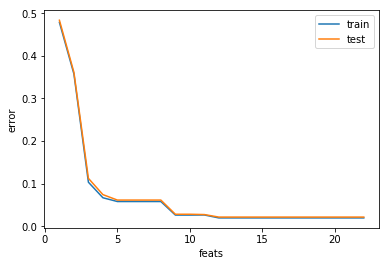

In [98]:
# making two lists 
trainer = list()
testerr = list()

ft = list(range(1,23))

for f in ft:
    svc = SVC(kernel = 'linear',gamma = 1e-06, C = 10)

    rfe = RFE(estimator = svc, n_features_to_select = f)

    rfe.fit(Xtrain, ytrain)
    Xtrain_sel = Xtrain.iloc[:, rfe.support_]
    Xtest_sel = Xtest.iloc[:, rfe.support_]
    
    errs = fit_and_report(svc, Xtrain_sel, ytrain, Xtest_sel, ytest)
    
    trainer.append(errs[0])
    testerr.append(errs[1])

# plotting the train and test error
plt.plot(ft, trainer, label="train")
plt.plot(ft, testerr, label="test")
plt.xlabel("Number of Features")
plt.ylabel("Error")
plt.legend()
plt.show()

I'm going to leave it at 10 features. With fewer than 10, the error is higher. With greater than 10, the error does not go down substantially.